# Test the specular reflection model

Testing is done by comparing the traced path loss maps to ones generated by [Sionna](https://nvlabs.github.io/sionna/) considering the same setup.

In [1]:
import os
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import mitsuba as mi

from sionna.rt import Scene, Transmitter, PlanarArray, Receiver
from instant_rm import MapTracer

# Simple reflector

In [3]:
# Test configuration

scene_file = "../scenes/simple_reflector/simple_reflector.xml"

tx_position = np.array([-0.5, 0., 1.0])
tx_orientation = np.array([0.0, 0.0, 0.0])
tx_pattern = 'iso'
fc = 3.5e9
tx_slant_angle = 0.0

cm_center = np.array([0., 0, 10.])
cm_orientation = np.array([0., 0., 0.])
cm_size = np.array([30., 30.])
cm_cell_size = np.array([0.1, 0.1])
num_samples = int(1e7)
max_depth = 1

# For visualization
vmin = -69 # dB
vmax = -64 # dB

# Compute material complex relative permittivities to ensure that
# Sionna and the evaluated tracer scene use the same values
eta_complex_mats = {}
scene = mi.load_file(scene_file)
eta_r = mi.traverse(scene)['mat-itu_metal.eta_r'].numpy()
eta_i = mi.traverse(scene)['mat-itu_metal.eta_i'].numpy()
eta_complex_mats['itu_metal'] = eta_r -1j*eta_i

/tmp/ipykernel_935992/2431412741.py:13: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(10.*np.log10(cm), vmin=vmin, vmax=vmax, origin='lower')


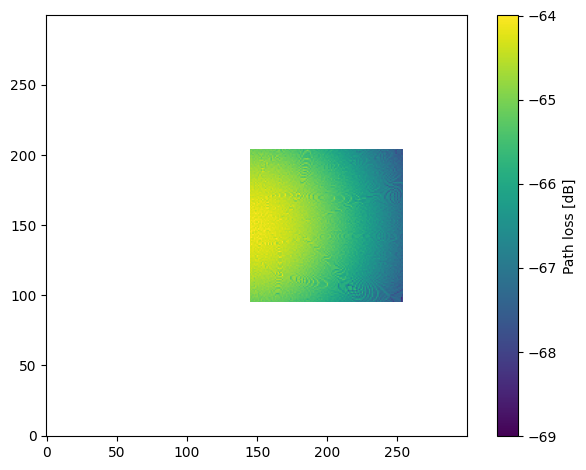

In [4]:
# Trace the path loss map with the evaluated tracer
scene = mi.load_file(scene_file)
tracer = MapTracer(scene, fc,
                   tx_pattern, tx_slant_angle,
                   cm_center, cm_orientation, cm_size, cm_cell_size,
                   num_samples, max_depth)
cm, _, _, _ = tracer(tx_position, tx_orientation, los=False)
cm = cm.numpy()

# Visualize
cm = cm.T
plt.figure()
plt.imshow(10.*np.log10(cm), vmin=vmin, vmax=vmax, origin='lower')
plt.colorbar(label="Path loss [dB]")
plt.tight_layout()

Mistmatch for complex relative permittivity of material itu_metal : [0.]


/tmp/ipykernel_935992/996247556.py:42: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(10.*np.log10(cm_ref), vmin=vmin, vmax=vmax, origin='lower')


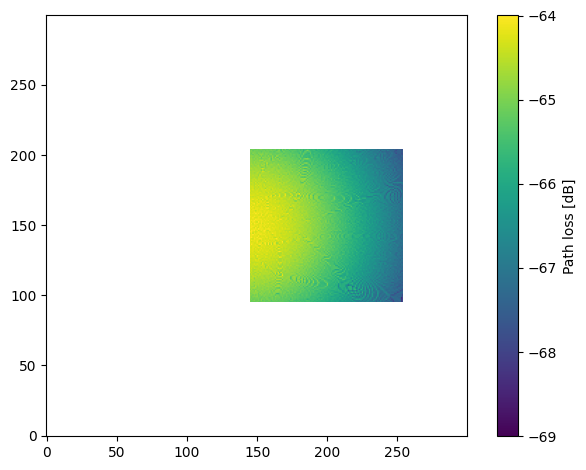

In [5]:
# Trace the path loss map with Sionna

scene = Scene(scene_file)
scene.frequency = fc

for rm_name, rm in scene.radio_materials.items():
    if not rm.is_used:
        continue
    err = np.abs(rm.complex_relative_permittivity - eta_complex_mats[rm_name])
    print(f"Mistmatch for complex relative permittivity of material {rm_name} : {err}")

# Configure antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern=tx_pattern,
                             polarization="V",
                             polarization_model=2)

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="iso",
                             polarization="VH",
                             polarization_model=2)
# Add a transmitters
tx = Transmitter(name="tx",
                 position=tx_position,
                 orientation=tx_orientation)
scene.add(tx)

# Compute path loss map
cm_ref = scene.coverage_map(cm_center=cm_center, cm_orientation=cm_orientation, cm_size=cm_size,
                            cm_cell_size=cm_cell_size, num_samples=num_samples, max_depth=max_depth,
                            check_scene=False, los=False, diffraction=False, scattering=False)
cm_ref = cm_ref.as_tensor().numpy()[0]

plt.figure()
plt.imshow(10.*np.log10(cm_ref), vmin=vmin, vmax=vmax, origin='lower')
plt.colorbar(label="Path loss [dB]")
plt.tight_layout()

/tmp/ipykernel_935992/49494246.py:3: RuntimeWarning: divide by zero encountered in log10
  cm_ref_db = 10.*np.log10(cm_ref)
/tmp/ipykernel_935992/49494246.py:4: RuntimeWarning: divide by zero encountered in log10
  cm_db = 10.*np.log10(cm)
/tmp/ipykernel_935992/49494246.py:5: RuntimeWarning: invalid value encountered in subtract
  err = np.abs(cm_ref_db - cm_db)


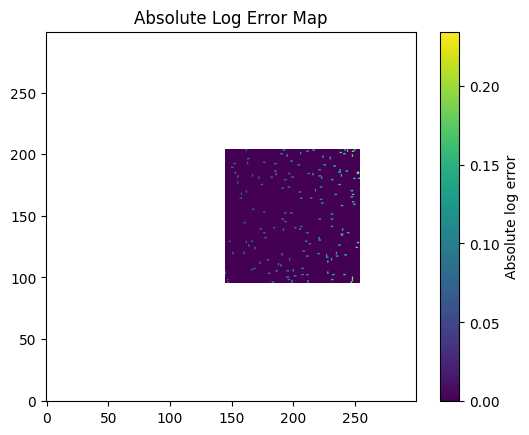

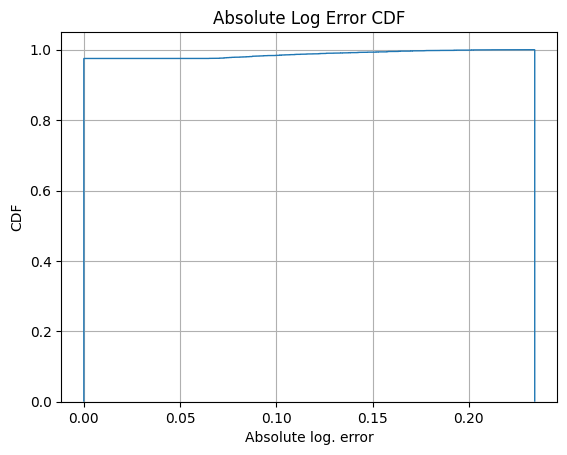

In [6]:
# Plot absolute log error map and CDF of absolute log error

cm_ref_db = 10.*np.log10(cm_ref)
cm_db = 10.*np.log10(cm)
err = np.abs(cm_ref_db - cm_db)

plt.figure()
plt.title("Absolute Log Error Map")
plt.imshow(err, origin='lower')
plt.colorbar(label="Absolute log error")

err = err[np.where(np.logical_not(np.logical_or(np.isinf(err), np.isnan(err))))]
plt.figure()
plt.title("Absolute Log Error CDF")
plt.hist(err.flatten(), bins=1000, cumulative=True, density=True, histtype='step');
plt.xlabel("Absolute log. error")
plt.ylabel("CDF")
plt.grid(True)

# Double reflector

In [7]:
# Test configuration

scene_file = "../scenes/double_reflector/double_reflector.xml"

tx_position = np.array([-10., 0.0, 1.])
tx_orientation = np.array([0.0, 0.0, 0.0])
tx_pattern = 'iso'
fc = 3.5e9
tx_slant_angle = 0.0

cm_center = np.array([10., 0, 0.])
cm_orientation = np.array([0., 0., 0.])
cm_size = np.array([10., 10.])
cm_cell_size = np.array([0.1, 0.1])
num_samples = int(1e7)
max_depth = 2

# For visualization
vmin = -100 # dB
vmax = -85 # dB

# scene = mi.load_file(scene_file)
eta_complex_mats = {}

# Compute material complex relative permittivities to ensure that
# Sionna and the evaluated tracer scene use the same values
scene = mi.load_file(scene_file)
eta_r = mi.traverse(scene)['mat-itu_metal.eta_r'].numpy()
eta_i = mi.traverse(scene)['mat-itu_metal.eta_i'].numpy()
eta_complex_mats['itu_metal'] = eta_r -1j*eta_i

/tmp/ipykernel_935992/3885562429.py:13: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(10.*np.log10(cm), vmin=vmin, vmax=vmax, origin='lower')


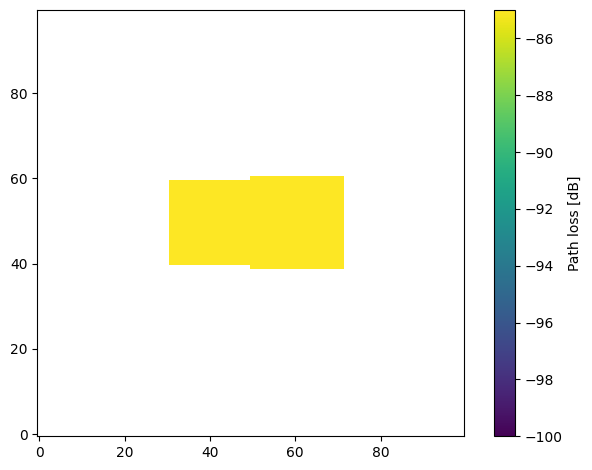

In [8]:
# Trace the path loss map with the evaluated tracer
scene = mi.load_file(scene_file)
tracer = MapTracer(scene, fc,
                   tx_pattern, tx_slant_angle,
                   cm_center, cm_orientation, cm_size, cm_cell_size,
                   num_samples, max_depth)
cm,_,_,_ = tracer(tx_position, tx_orientation, los=False)
cm = cm.numpy()

# Visualize
cm = cm.T
plt.figure()
plt.imshow(10.*np.log10(cm), vmin=vmin, vmax=vmax, origin='lower')
plt.colorbar(label="Path loss [dB]")
plt.tight_layout()

Mistmatch for complex relative permittivity of material itu_metal : [0.]


/tmp/ipykernel_935992/2055969770.py:43: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(10.*np.log10(cm_ref), vmin=vmin, vmax=vmax, origin='lower')


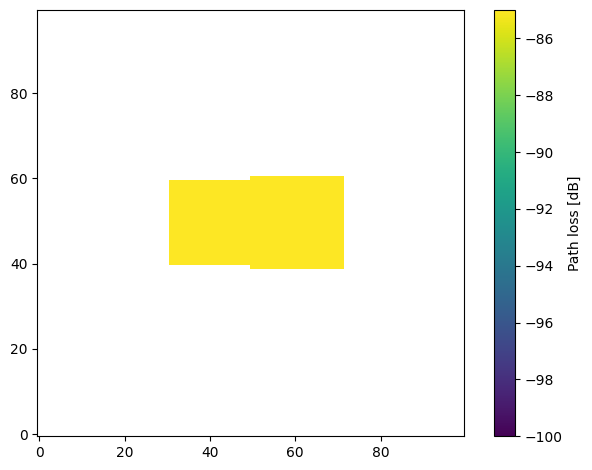

In [9]:
# Trace the path loss map with Sionna

scene = Scene(scene_file)
scene.frequency = fc

for rm_name, rm in scene.radio_materials.items():
    if not rm.is_used:
        continue
    err = np.abs(rm.complex_relative_permittivity - eta_complex_mats[rm_name])
    print(f"Mistmatch for complex relative permittivity of material {rm_name} : {err}")


# Configure antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern=tx_pattern,
                             polarization="V",
                             polarization_model=2)

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="iso",
                             polarization="VH",
                             polarization_model=2)
# Add a transmitters
tx = Transmitter(name="tx",
                 position=tx_position,
                 orientation=tx_orientation)
scene.add(tx)

# Compute path loss map
cm_ref = scene.coverage_map(cm_center=cm_center, cm_orientation=cm_orientation, cm_size=cm_size,
                            cm_cell_size=cm_cell_size, num_samples=num_samples, max_depth=max_depth,
                            check_scene=False, los=False, diffraction=False, scattering=False)
cm_ref = cm_ref.as_tensor().numpy()[0]

plt.figure()
plt.imshow(10.*np.log10(cm_ref), vmin=vmin, vmax=vmax, origin='lower')
plt.colorbar(label="Path loss [dB]")
plt.tight_layout()

/tmp/ipykernel_935992/49494246.py:3: RuntimeWarning: divide by zero encountered in log10
  cm_ref_db = 10.*np.log10(cm_ref)
/tmp/ipykernel_935992/49494246.py:4: RuntimeWarning: divide by zero encountered in log10
  cm_db = 10.*np.log10(cm)
/tmp/ipykernel_935992/49494246.py:5: RuntimeWarning: invalid value encountered in subtract
  err = np.abs(cm_ref_db - cm_db)


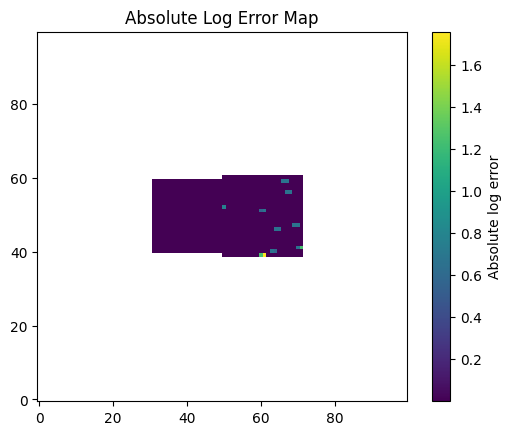

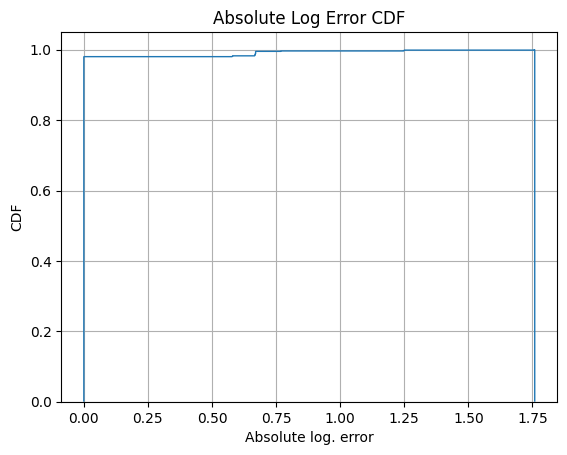

In [10]:
# Plot absolute log error map and CDF of absolute log error

cm_ref_db = 10.*np.log10(cm_ref)
cm_db = 10.*np.log10(cm)
err = np.abs(cm_ref_db - cm_db)

plt.figure()
plt.title("Absolute Log Error Map")
plt.imshow(err, origin='lower')
plt.colorbar(label="Absolute log error")

err = err[np.where(np.logical_not(np.logical_or(np.isinf(err), np.isnan(err))))]
plt.figure()
plt.title("Absolute Log Error CDF")
plt.hist(err.flatten(), bins=1000, cumulative=True, density=True, histtype='step');
plt.xlabel("Absolute log. error")
plt.ylabel("CDF")
plt.grid(True)

# Test on Etoile

In [11]:
# Test configuration

scene_file = "../scenes/etoile/etoile.xml"

tx_position = np.array([0., 0., 20.])
tx_orientation = np.array([0.0, 0.0, 0.0])
tx_pattern = 'iso'
fc = 3.5e9
tx_slant_angle = 0.0

cm_center = np.array([0., 0, 1.5])
cm_orientation = np.array([0., 0., 0.])
cm_size = np.array([500., 500.])
cm_cell_size = np.array([1., 1.])
num_samples = int(1e7)
max_depth = 3

vmin = -120
vmax = -70

/tmp/ipykernel_935992/490878453.py:10: RuntimeWarning: divide by zero encountered in log10
  cm_db = 10.*np.log10(cm.T)


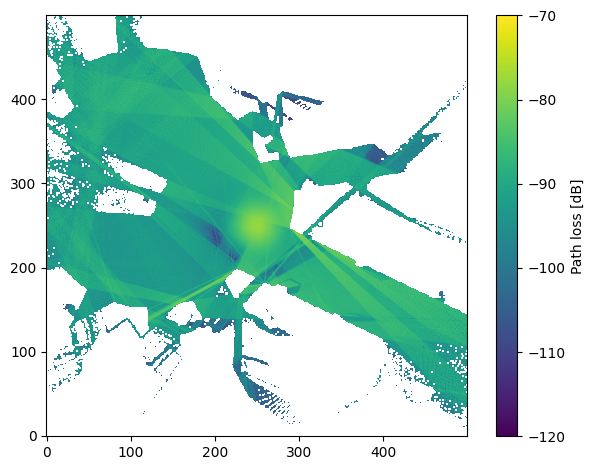

In [12]:
scene = mi.load_file(scene_file)
tracer = MapTracer(scene, fc,
                   tx_pattern, tx_slant_angle,
                   cm_center, cm_orientation, cm_size, cm_cell_size,
                   num_samples, max_depth)
cm,_,_,_ = tracer(tx_position, tx_orientation, los=False)
cm = cm.numpy()

plt.figure()
cm_db = 10.*np.log10(cm.T)
plt.imshow(cm_db, origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar(label="Path loss [dB]")
plt.tight_layout()

/tmp/ipykernel_935992/4220300198.py:35: RuntimeWarning: divide by zero encountered in log10
  cm_ref_db = 10.*np.log10(cm_ref)


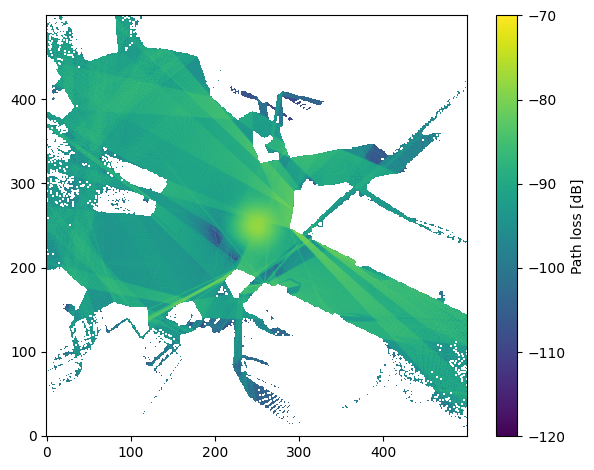

In [13]:
# Trace the path loss map with Sionna

scene = Scene(scene_file)
scene.frequency = fc

# Configure antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern=tx_pattern,
                             polarization="V",
                             polarization_model=2)

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="iso",
                             polarization="VH",
                             polarization_model=2)
# Add a transmitters
tx = Transmitter(name="tx",
                 position=tx_position,
                 orientation=tx_orientation)
scene.add(tx)

cm_ref = scene.coverage_map(cm_center=cm_center, cm_orientation=cm_orientation, cm_size=cm_size,
                            cm_cell_size=cm_cell_size, num_samples=num_samples, max_depth=max_depth,
                            check_scene=False, los=False, diffraction=False, scattering=False)
cm_ref = cm_ref.as_tensor().numpy()[0]

plt.figure()
cm_ref_db = 10.*np.log10(cm_ref)
plt.imshow(cm_ref_db, origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar(label="Path loss [dB]")
plt.tight_layout()

/tmp/ipykernel_935992/3503880221.py:2: RuntimeWarning: invalid value encountered in subtract
  plt.imshow(np.abs(cm_ref_db-cm_db), origin='lower', vmax=2)


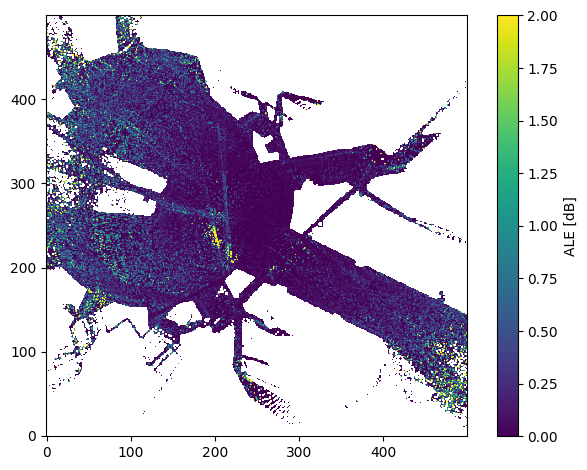

In [14]:
plt.figure()
plt.imshow(np.abs(cm_ref_db-cm_db), origin='lower', vmax=2)
plt.colorbar(label="ALE [dB]")
plt.tight_layout()